In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
import random
import io

## Load Data and Define Functions

In [45]:
#Load Customer profiles
customer_profiles = pd.read_csv('Customer_Profiles.csv')
customer_profiles.set_index('Customer_Cluster', inplace = True)
customer_profiles = customer_profiles.loc[:, ~customer_profiles.columns.str.contains('^Unnamed')]
customer_profiles.head()

,Gender,Style,Blouses,Dresses,Jackets & Coats,Jeans,Jumpers,Polos,Shirts,Shorts,Skirts,Suits,Trousers,T-Shirts
Customer_Cluster,,,,,,,,,,,,,,
1.0,Mens,Casual,0.0,0.0,0.1,0.20,0.10,0.10,0.00,0.20,0.0,0.0,0.00,0.30
2.0,Mens,Casual,0.0,0.0,0.2,0.15,0.15,0.00,0.05,0.10,0.0,0.0,0.00,0.35
3.0,Mens,Casual,0.0,0.0,0.1,0.20,0.15,0.20,0.05,0.10,0.0,0.0,0.00,0.20
4.0,Mens,Casual,0.0,0.0,0.2,0.00,0.10,0.15,0.10,0.15,0.0,0.0,0.15,0.15
5.0,Mens,Casual,0.0,0.0,0.0,0.25,0.00,0.20,0.00,0.20,0.0,0.0,0.00,0.35


In [46]:
#Load Shop Profiles
shop_profiles = pd.read_csv('Shop_Profiles.csv')
shop_profiles.set_index('Shop_Cluster', inplace = True)
shop_profiles = shop_profiles.loc[:, ~shop_profiles.columns.str.contains('^Unnamed')]
shop_profiles.head()

,Gender,Style,Adidas,CalvinKleinMen,CalvinKleinPerformance,CalvinKleinWomen,Max&Co,MaxMara,Muji,Nike,Brooks Brothers,Boss,Fred Perry,Saint Laurent,Uniqlo,Moncler,Ralph_Lauren
Shop_Cluster,,,,,,,,,,,,,,,,,
1,Mens,Casual,0.1,0.15,0.1,0.00,0.0,0.00,0.10,0.15,0.0,0.0,0.1,0.05,0.15,0.0,0.1
2,Womens,Casual,0.1,0.00,0.1,0.15,0.1,0.00,0.10,0.10,0.0,0.0,0.1,0.00,0.15,0.0,0.1
3,Mens,Casual,0.1,0.15,0.1,0.00,0.0,0.00,0.15,0.05,0.1,0.0,0.1,0.05,0.20,0.0,0.0
4,Womens,Casual,0.1,0.00,0.1,0.15,0.1,0.15,0.10,0.00,0.0,0.0,0.1,0.00,0.20,0.0,0.0
5,Mens,Smart,0.0,0.10,0.0,0.00,0.0,0.00,0.00,0.00,0.2,0.1,0.1,0.10,0.00,0.2,0.2


In [47]:
#Load Product db
products = pd.read_csv('AllCombined.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.head()

,ID,Brand,Category,Gender,Name,Image URL,Price
0,1.0,Adidas,T-Shirts,Mens,HUMAN MADE GRAPHIC TEE,http://img.adidas.com.hk/resources/2021/4/13/1...,699
1,2.0,Adidas,T-Shirts,Mens,TREFOIL GRAPHIC PACK SHORT SLEEVE TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,499
2,3.0,Adidas,T-Shirts,Mens,HEAT.RDY RUNNING TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,329
3,4.0,Adidas,T-Shirts,Mens,DAME AVATAR POCKET TEE,http://img.adidas.com.hk/resources/2021/3/30/1...,269
4,5.0,Adidas,T-Shirts,Mens,ADICOLOR PREMIUM TEE (GENDER NEUTRAL),http://img.adidas.com.hk/resources/2021/3/30/1...,399


In [50]:
#Function to generate user history database
#Either appends to the existing user_df, or can create a new one if user_df input is empty
def generate_user_history_profiles(no_of_users, min_items, max_items, products_df = products, shop_profiles = shop_profiles, customer_profiles = customer_profiles, csv = 'new'):
#remove seeds when running multiple times, otherwise data will be the same between runs
    random.seed(10)
    np.random.seed(10) 
#load in new or existing df
    if csv == 'new':
        new_columns = ['User_ID', 'ID', 'Brand', 'Category', 'Gender', 'Name', 'Image URL', 'Price', 'Customer_Cluster', 'Shop_Cluster']
        user_df = pd.DataFrame(columns = new_columns)
    else:
        user_df = pd.read_csv(csv)
        user_df = user_df.loc[:, ~user_df.columns.str.contains('^Unnamed')]   
#Begin loop to create each user in df
    for user in range(no_of_users): 
    #Define User ID
        if len(user_df) == 0:
            user_id = 1
        else: 
            user_id = max(user_df['User_ID'])+1
    #Randomly assign gender and number of items bought by user
        gender_list = ['Mens', 'Womens']
        gender = gender_list[random.randint(0,1)]
        items_bought = random.randint(min_items, max_items)
    #Randomly select Customer_Cluster and Shop Cluster
        customer_cluster = customer_profiles[customer_profiles['Gender']==gender].sample(1)
        shop_cluster = shop_profiles[(shop_profiles['Style']==customer_cluster['Style'].values[0]) & (shop_profiles['Gender']==gender)].sample(1)
    #Calculate customer matrix using the Customer_cluster * Shop_cluster
        customer_np = np.array(customer_cluster.iloc[:,2:])
        shop_np = np.array(shop_cluster.iloc[:,2:])
        mat = np.zeros(shape=(shop_np.shape[1],customer_np.shape[1]))
        for row in range(0,shop_np.shape[1]):
            mat[row] = shop_np[0][row]*customer_np[0]
    # Save as dataframe
        customer_matrix = pd.DataFrame(mat, columns = customer_cluster.columns[2:])
        customer_matrix['Shop'] = shop_cluster.columns[2:]
        customer_matrix.set_index('Shop', inplace = True)
        customer_matrix = (customer_matrix*items_bought).round(0)
        for shop in customer_matrix.index:
            for category in customer_matrix.columns:
                try:
                    n = int(customer_matrix.at[shop, category])
                    dummy_df = products_df[(products_df['Brand']==shop) & (products_df['Category']==category) & (products_df['Gender']==gender)].sample(n + random.randint(-round(n/2,0), round(n/2,0)))
                    dummy_df['User_ID'] = user_id
                    dummy_df['Customer_Cluster'] = int(customer_cluster.index[0])
                    dummy_df['Shop_Cluster'] = int(shop_cluster.index[0])
                    user_df = user_df.append(dummy_df)
                except:
                    pass
        print(f'Completed user {user_id}\nItems Purchased: {items_bought}\nCustomer Cluster: {int(customer_cluster.index[0])}\nShop_Cluster: {int(shop_cluster.index[0])}\n')
    return user_df

## Generate User Shopping History

In [51]:
#Set parameters
no_of_users = 200
min_items = 25
max_items = 100

#Run Function to generate users
user_df = generate_user_history_profiles(no_of_users, min_items = 10, max_items = 100, products_df = products, shop_profiles = shop_profiles, customer_profiles = customer_profiles, csv = 'new')

Completed user 1
Items Purchased: 64
Customer Cluster: 3
Shop_Cluster: 1

Completed user 2
Items Purchased: 54
Customer Cluster: 4
Shop_Cluster: 1

Completed user 3
Items Purchased: 94
Customer Cluster: 15
Shop_Cluster: 6

Completed user 4
Items Purchased: 81
Customer Cluster: 17
Shop_Cluster: 6

Completed user 5
Items Purchased: 100
Customer Cluster: 17
Shop_Cluster: 6

Completed user 6
Items Purchased: 95
Customer Cluster: 13
Shop_Cluster: 5

Completed user 7
Items Purchased: 81
Customer Cluster: 21
Shop_Cluster: 8

Completed user 8
Items Purchased: 21
Customer Cluster: 11
Shop_Cluster: 5

Completed user 9
Items Purchased: 77
Customer Cluster: 2
Shop_Cluster: 1

Completed user 10
Items Purchased: 98
Customer Cluster: 15
Shop_Cluster: 6

Completed user 11
Items Purchased: 94
Customer Cluster: 20
Shop_Cluster: 7

Completed user 12
Items Purchased: 82
Customer Cluster: 22
Shop_Cluster: 8

Completed user 13
Items Purchased: 52
Customer Cluster: 14
Shop_Cluster: 5

Completed user 14
Items

In [55]:
#Save df to csv
user_df.to_csv('User_db.csv', index = False)

## Check Distributions of Generated Data

In [60]:
#Load csv file
user_df = pd.read_csv('User_db.csv')
user_df.head(10)

,User_ID,ID,Brand,Category,Gender,Name,Image URL,Price,Customer_Cluster,Shop_Cluster
0,1,33.0,Adidas,Jackets & Coats,Mens,CNY JACKET,http://img.adidas.com.hk/resources/2020/12/29/...,999,3,1
1,1,36.0,Adidas,Jumpers,Mens,ESSENTIALS EMBROIDERED SMALL LOGO SWEATSHIRT,http://img.adidas.com.hk/resources/2020/12/28/...,299,3,1
2,1,35.0,Adidas,Polos,Mens,ADIPURE PREMIUM ENGINEERED POLO SHIRT,http://img.adidas.com.hk/resources/2020/8/27/1...,780,3,1
3,1,55.0,Adidas,Shorts,Mens,MANCHESTER UNITED 20/21 AWAY SHORTS,http://img.adidas.com.hk/resources/2020/8/14/1...,369,3,1
4,1,53.0,Adidas,T-Shirts,Mens,GERMANY HOME JERSEY,http://img.adidas.com.hk/resources/2019/10/29/...,599,3,1
5,1,21.0,CalvinKleinMen,Jackets & Coats,Mens,logo grid anorak,https://images.demandware.net/dw/image/v2/ABAD...,995,3,1
6,1,12.0,CalvinKleinMen,Jeans,Mens,ckj 017 freecross body skinny jeans,https://images.demandware.net/dw/image/v2/ABAD...,NaN,3,1
7,1,18.0,CalvinKleinMen,Jumpers,Mens,ck badge organic cotton sweatshirt,https://images.demandware.net/dw/image/v2/ABAD...,790,3,1
8,1,27.0,CalvinKleinMen,T-Shirts,Mens,institutional logo slim tee,https://images.demandware.net/dw/image/v2/ABAD...,390,3,1
9,1,4.0,CalvinKleinMen,T-Shirts,Mens,tonal embroidered logo tee,https://images.demandware.net/dw/image/v2/ABAD...,750,3,1


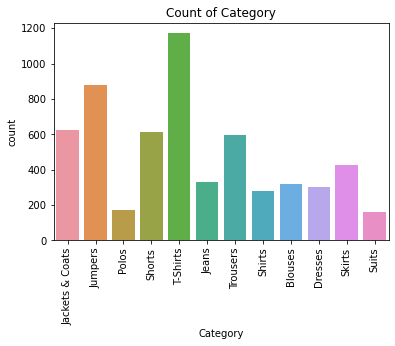

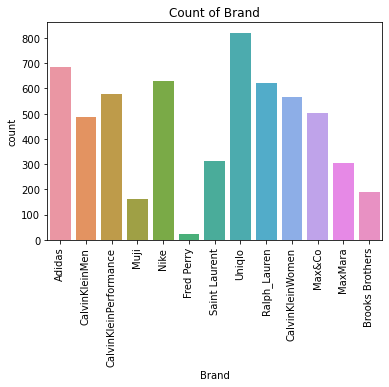

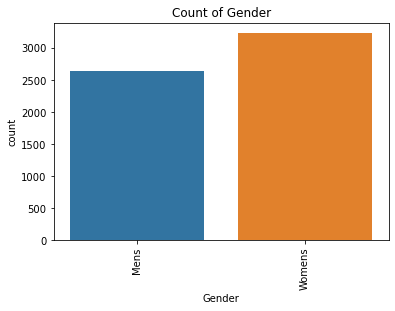

In [57]:
#Plot count of category / brand
for item in ['Category', 'Brand', 'Gender']:
    sns.countplot(data = user_df, x = item)
    plt.xticks(rotation = 90)
    plt.title(f'Count of {item}')
    plt.show()

<AxesSubplot:xlabel='Category', ylabel='Brand'>

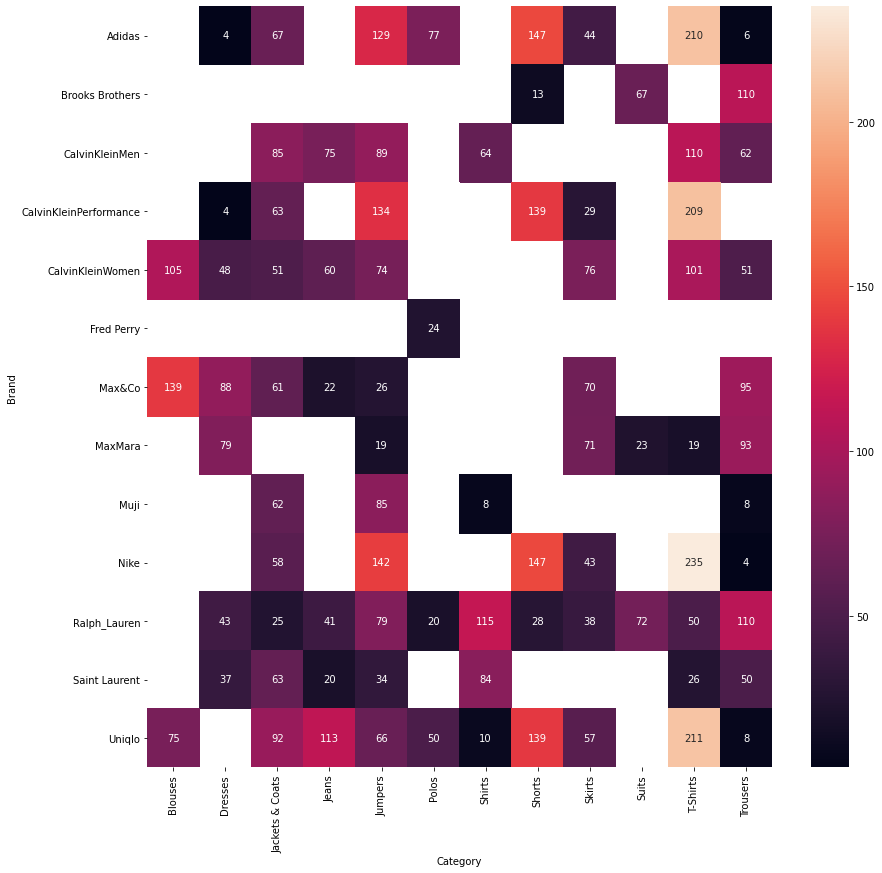

In [58]:
#Plot heatmap of brands/categories in the database
user_pivot = user_df.pivot_table(index = 'Brand', columns = 'Category', values = 'Name', aggfunc = 'count')
fig, ax = plt.subplots(figsize = (14,14))
sns.heatmap(ax = ax, data = user_pivot, annot = True, fmt = '.0f')

## Check Example User

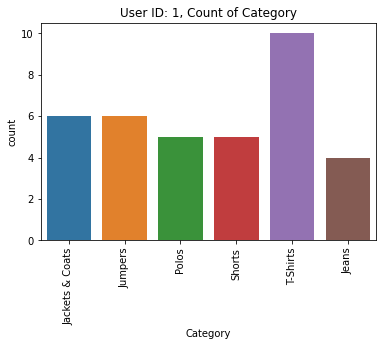

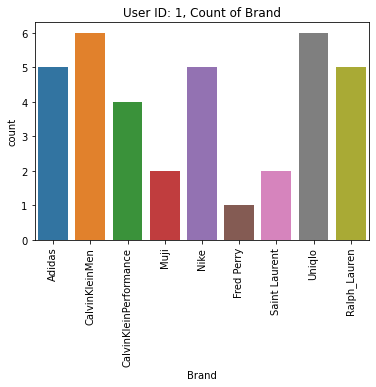

In [59]:
# Example user
example_user_id = 1

for item in ['Category', 'Brand']:
    sns.countplot(data = user_df[user_df['User_ID']==example_user_id], x = item)
    plt.title(f'User ID: {example_user_id}, Count of {item}')
    plt.xticks(rotation = 90)
    plt.show()